
# <span style="color:rgb(213,80,0)">Generate Electrical Efficiency/Losses Data for Synchronous Motor Drive System</span>

Copyright 2020 The MathWorks, Inc.


The purpose of this script is to calculate **the total electrical efficiency/losses of synchronous motor drive system** using a detailed 3-phase AC system model.


The model [MotorDrive_testHarness.slx](matlab:open_system("MotorDrive_testHarness")) consists of the detailed 3-phase synchronous motor, interver, and motor controller. This script runs the model in various operating conditions to collect AC steady-state data, and then computes electrical losses in the post process. The losses data produced in this script can be used in **Simplified PMSM Drive** block in Simscape Electrical for fast-running simulation purpose.

## Set up

In [1]:
% Load parameters
MotorDrive_testParams

% Open model and set up simulation
mdl = "MotorDrive_testHarness";
if not(bdIsLoaded(mdl)), open_system(mdl); end

set_param(mdl, ...
  'SimscapeLogOpenViewer', 'off',...
  'EnablePacing', 'off',...
  'SolverType', 'Variable-step',...
  'Solver', 'VariableStepAuto',...
  'SaveTime', 'on',...
  'TimeSaveName', 'tout',...
  'SignalLogging', 'on',...
  'SignalLoggingName', 'logsout',...
  'SimscapeLogType', 'local',...
  'SimscapeLogSimulationStatistics', 'off',...
  'SimscapeLogToSDI', 'off',...
  'SimscapeLogName', 'logsoutssc',...
  'SimscapeLogDecimation', 1,...
  'SimscapeLogLimitData', 'off',...
  'ReturnWorkspaceOutputs', 'on',...
  'ReturnWorkspaceOutputsName', 'out');

set_param(mdl+"/Motor Drive/FEM-Parameterized PMSM", "LogSimulationData", "on")
  % necessary for electrical loss calculation after simulation

tMax = 0.2;  % Simulation time > 60/rpm0/N
set_param(mdl, 'StopTime',num2str(tMax))

set_param(mdl, 'FastRestart', 'on')
save_system(mdl)

prjRoot = currentProject().RootFolder;
topicFolderPath = fullfile(prjRoot, "DetailedModelApplications", "MotorDrivePmsmFem");
assert(isfolder(topicFolderPath))

## Run Simulations

Generate a simulation input data set in different operating conditions to collect physical signals in AC steady state.

#### Define torque and speed conditions

In [2]:
% The ranges specified below are rather narrow for electric vehicle motors.
% This is due to the lack of sufficient motor data for FEM-Parameterized PMSM block
% as well as to the limitation of the FOC controller used in the model.
SpeedVec = [100, 450, 800, 1150, 1500];  % rpm
TorqueVec = [10, 45, 80, 115, 150];  % N*m

#### **Build simulation input data set and run simulations**

In [3]:
nS = length(SpeedVec);
nT = length(TorqueVec);

clear in
in(1:nS, 1:nT) = Simulink.SimulationInput(mdl);
for i_spd = 1:nS
  for i_trq = 1:nT
    rpm0 = SpeedVec(i_spd);
    torque0 = TorqueVec(i_trq);

    % First two setBlockParameter calls are used by Simulation Manager's
    % default Figure window to show the progress of simulations.
    % First one for horizontal, left to right.
    % Second one for vertical, bottom to top.
    in(i_spd,i_trq) = in(i_spd,i_trq).setBlockParameter(mdl+"/Constant Target Speed", 'Value',num2str(rpm0));
    in(i_spd,i_trq) = in(i_spd,i_trq).setBlockParameter(mdl+"/Step Load Torque", 'After',num2str(torque0));

    in(i_spd,i_trq) = in(i_spd,i_trq).setBlockParameter(mdl+"/Load inertia", 'w',num2str(rpm0));
    in(i_spd,i_trq) = in(i_spd,i_trq).setBlockParameter(mdl+"/Motor Drive/FEM-Parameterized PMSM", ...
                'angular_velocity',num2str(rpm0));
    in(i_spd,i_trq) = in(i_spd,i_trq).setBlockParameter(mdl+"/Motor Drive/FEM-Parameterized PMSM", ...
                'angular_velocity_priority','High');
  end
end

%out = sim(in, "ShowSimulationManager","on");
out = parsim(in, "ShowSimulationManager","on");  % need Parallel Computing Toolbox

[15-Dec-2023 15:42:46] Checking for availability of parallel pool...
Starting parallel pool (parpool) using the 'Processes' profile ...
Connected to parallel pool with 4 workers.
[15-Dec-2023 15:44:19] Starting Simulink on parallel workers...
[15-Dec-2023 15:44:43] Loading project on parallel workers...
[15-Dec-2023 15:44:43] Configuring simulation cache folder on parallel workers...
[15-Dec-2023 15:45:01] Loading model on parallel workers...
[15-Dec-2023 15:45:33] Running simulations...
[15-Dec-2023 15:49:39] Cleaning up parallel workers...

## **Visually Inspect Motor Speed Behavior**


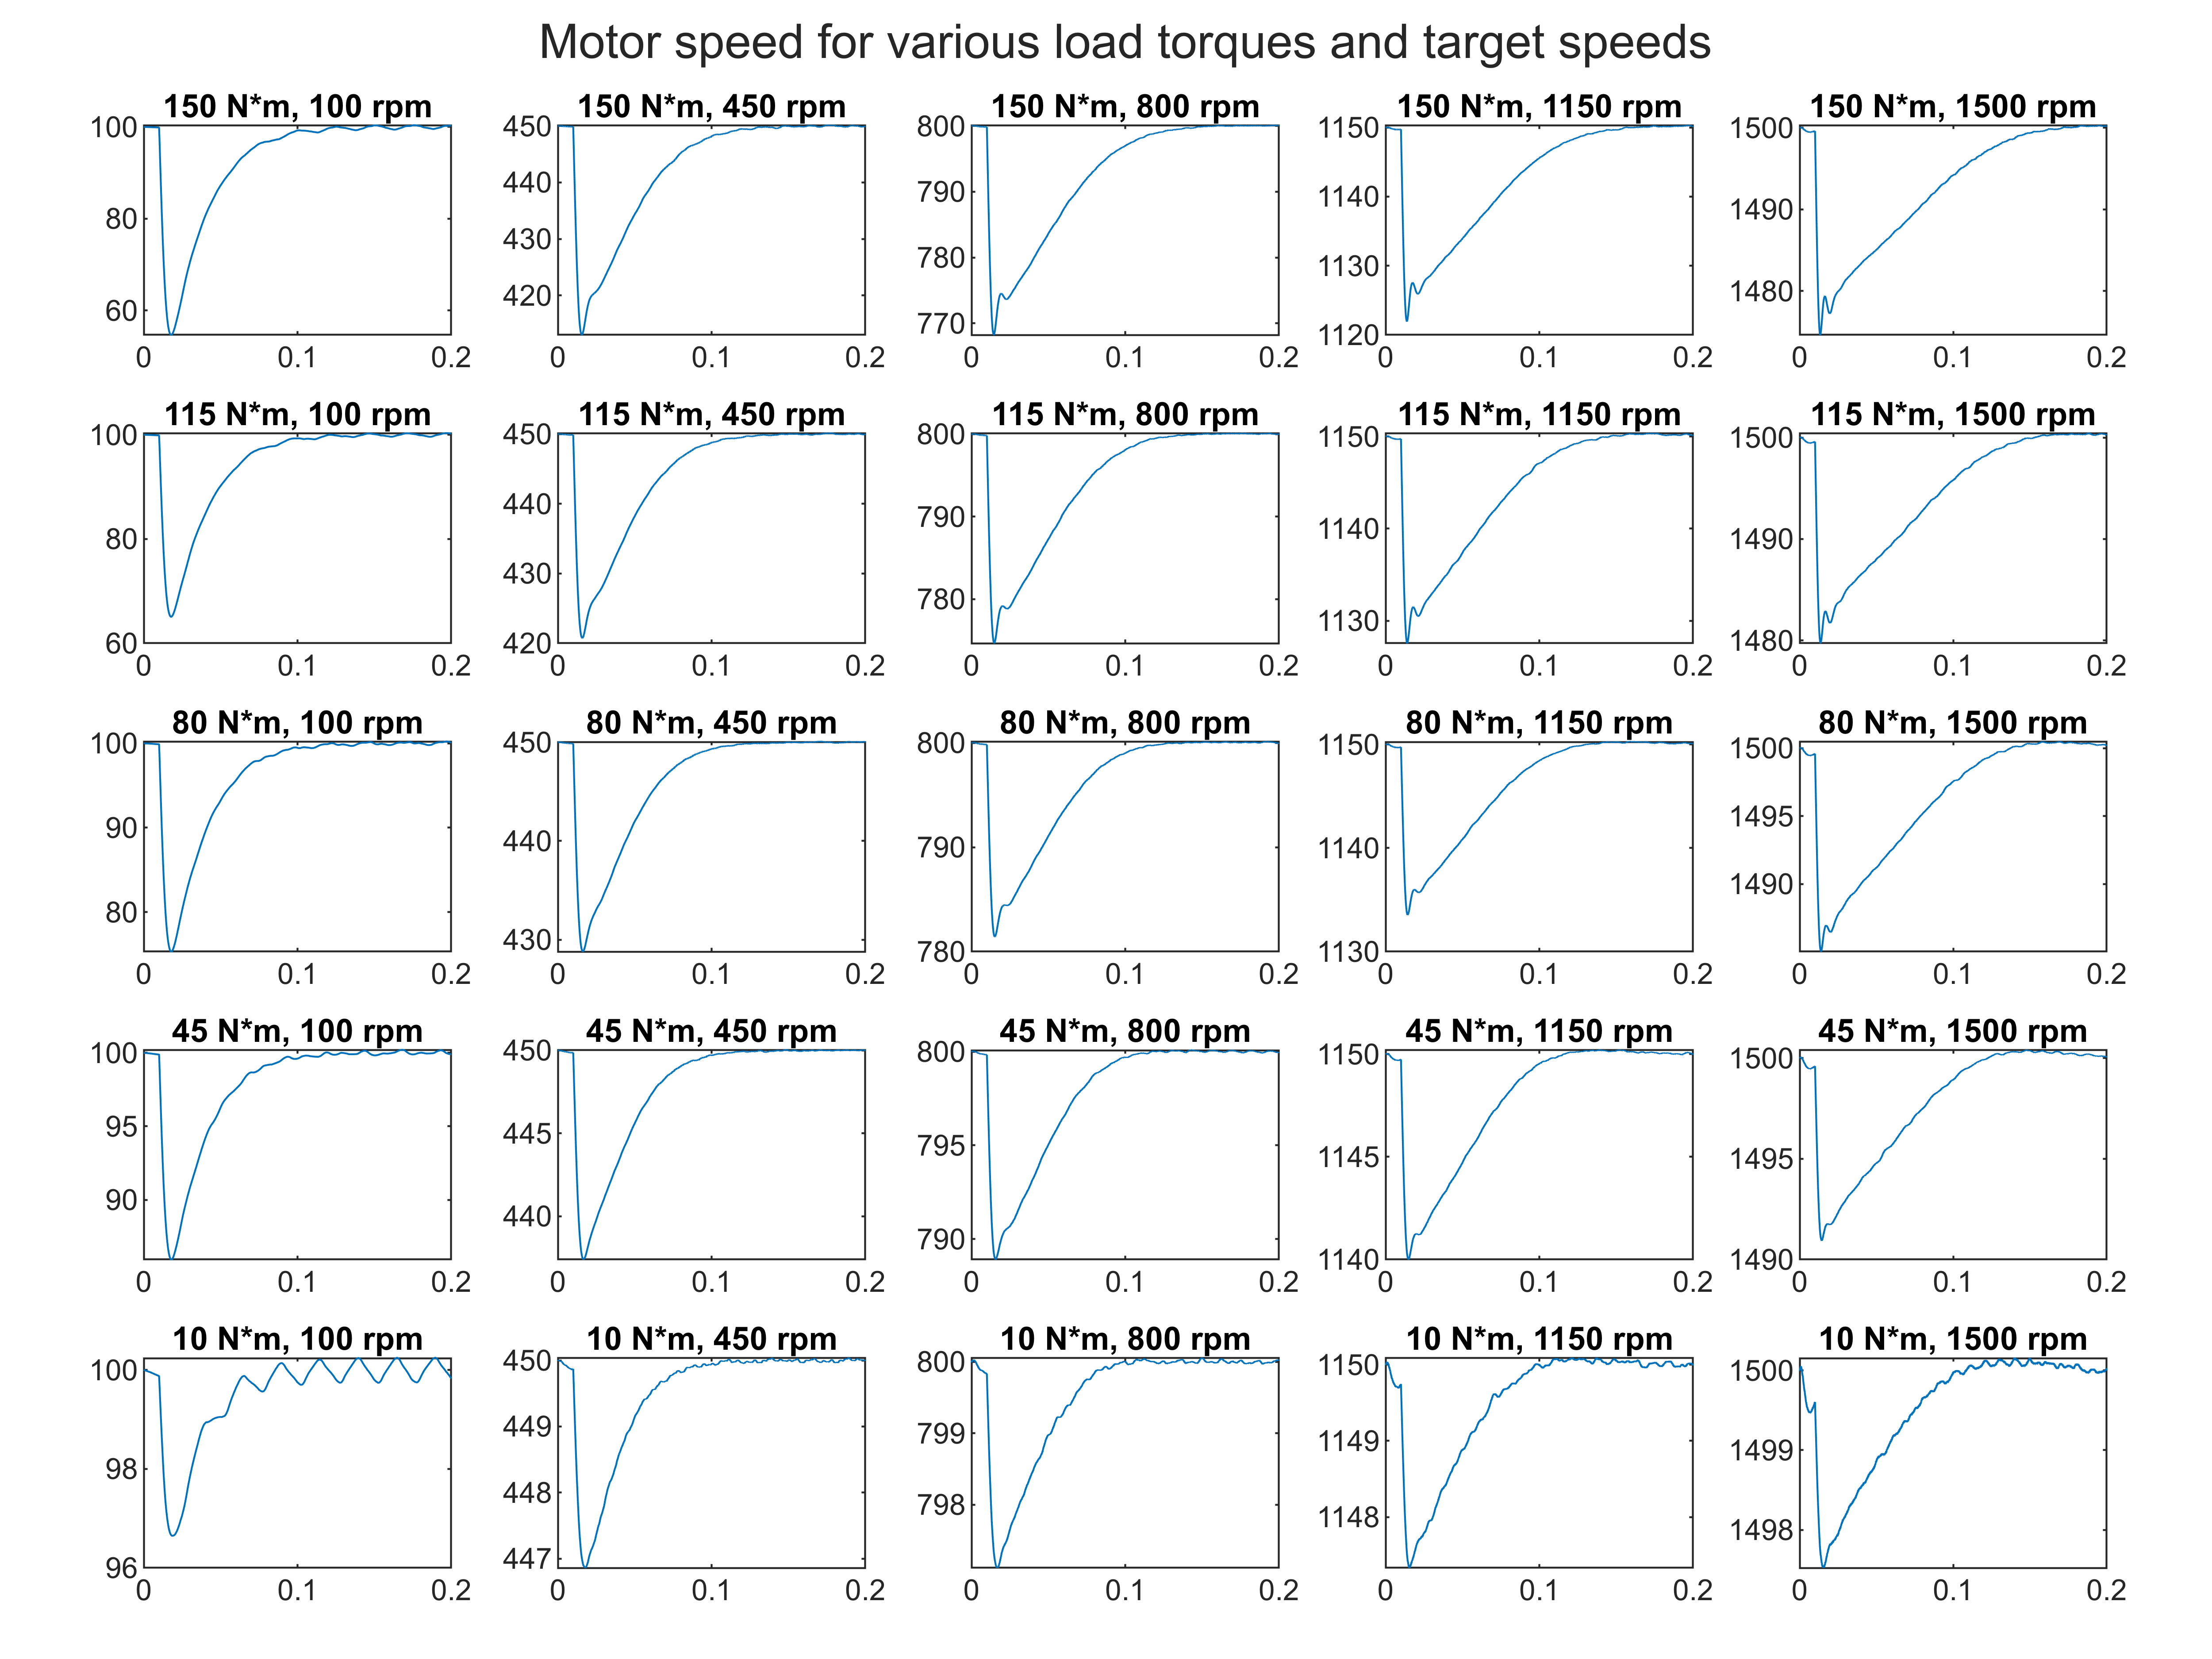

In [4]:
clear result
result(1:nS,1:nT) = struct('spd',0, 'trq',0, 'log',timeseries);
for i_spd = 1:nS  % speed
  for i_trq = 1:nT  % torque
    spd = SpeedVec(i_spd);
    trq = TorqueVec(i_trq);
    result(i_spd,i_trq).spd = spd;
    result(i_spd,i_trq).trq = trq;
    result(i_spd,i_trq).log = out(i_spd,i_trq).logsout.get("<motorSpd>").Values;
  end
end

f = figure;
f.Position(3:4) = [800 600];
tl = tiledlayout(nT, nS);
tl.TileSpacing = "compact";
tl.Padding = "compact";
title(tl, "Motor speed for various load torques and target speeds")
for i_trq = 1:nT  % torque
  for i_spd = 1:nS  % speed
    nexttile
    irev_trq = nT - i_trq + 1;
    plot(result(i_spd,irev_trq).log.Time, result(i_spd,irev_trq).log.Data)
    title(num2str(result(i_spd,irev_trq).trq) + " N*m, " + num2str(result(i_spd,irev_trq).spd) + " rpm")
  end
end

## Obtain Electrical Losses

Use the [ee_getPowerLossSummary](matlab:web(fullfile(docroot, 'physmod/sps/ref/ee_getpowerlosssummary.html'))) API from Simscape Electrical to obtain electrical losses in the motor. Make sure the signals in the motor block were logged during simulation.


In [5]:
Losses = zeros(nS,nT);
for i_spd = 1:nS
  for i_trq = 1:nT
    rpm0_abs = abs(SpeedVec(i_spd));
    % Time range for last full AC cycle
    tMin = tMax - 60/rpm0_abs/PmsmFem.NumPolePairs;
    assert(tMin < tMax)
    % Extract losses
    tabulatedLosses = ee_getPowerLossSummary(out(i_spd,i_trq).logsoutssc, tMin, tMax);
    Losses(i_spd,i_trq) = sum(tabulatedLosses.Power);
  end
end


 **Visualize**



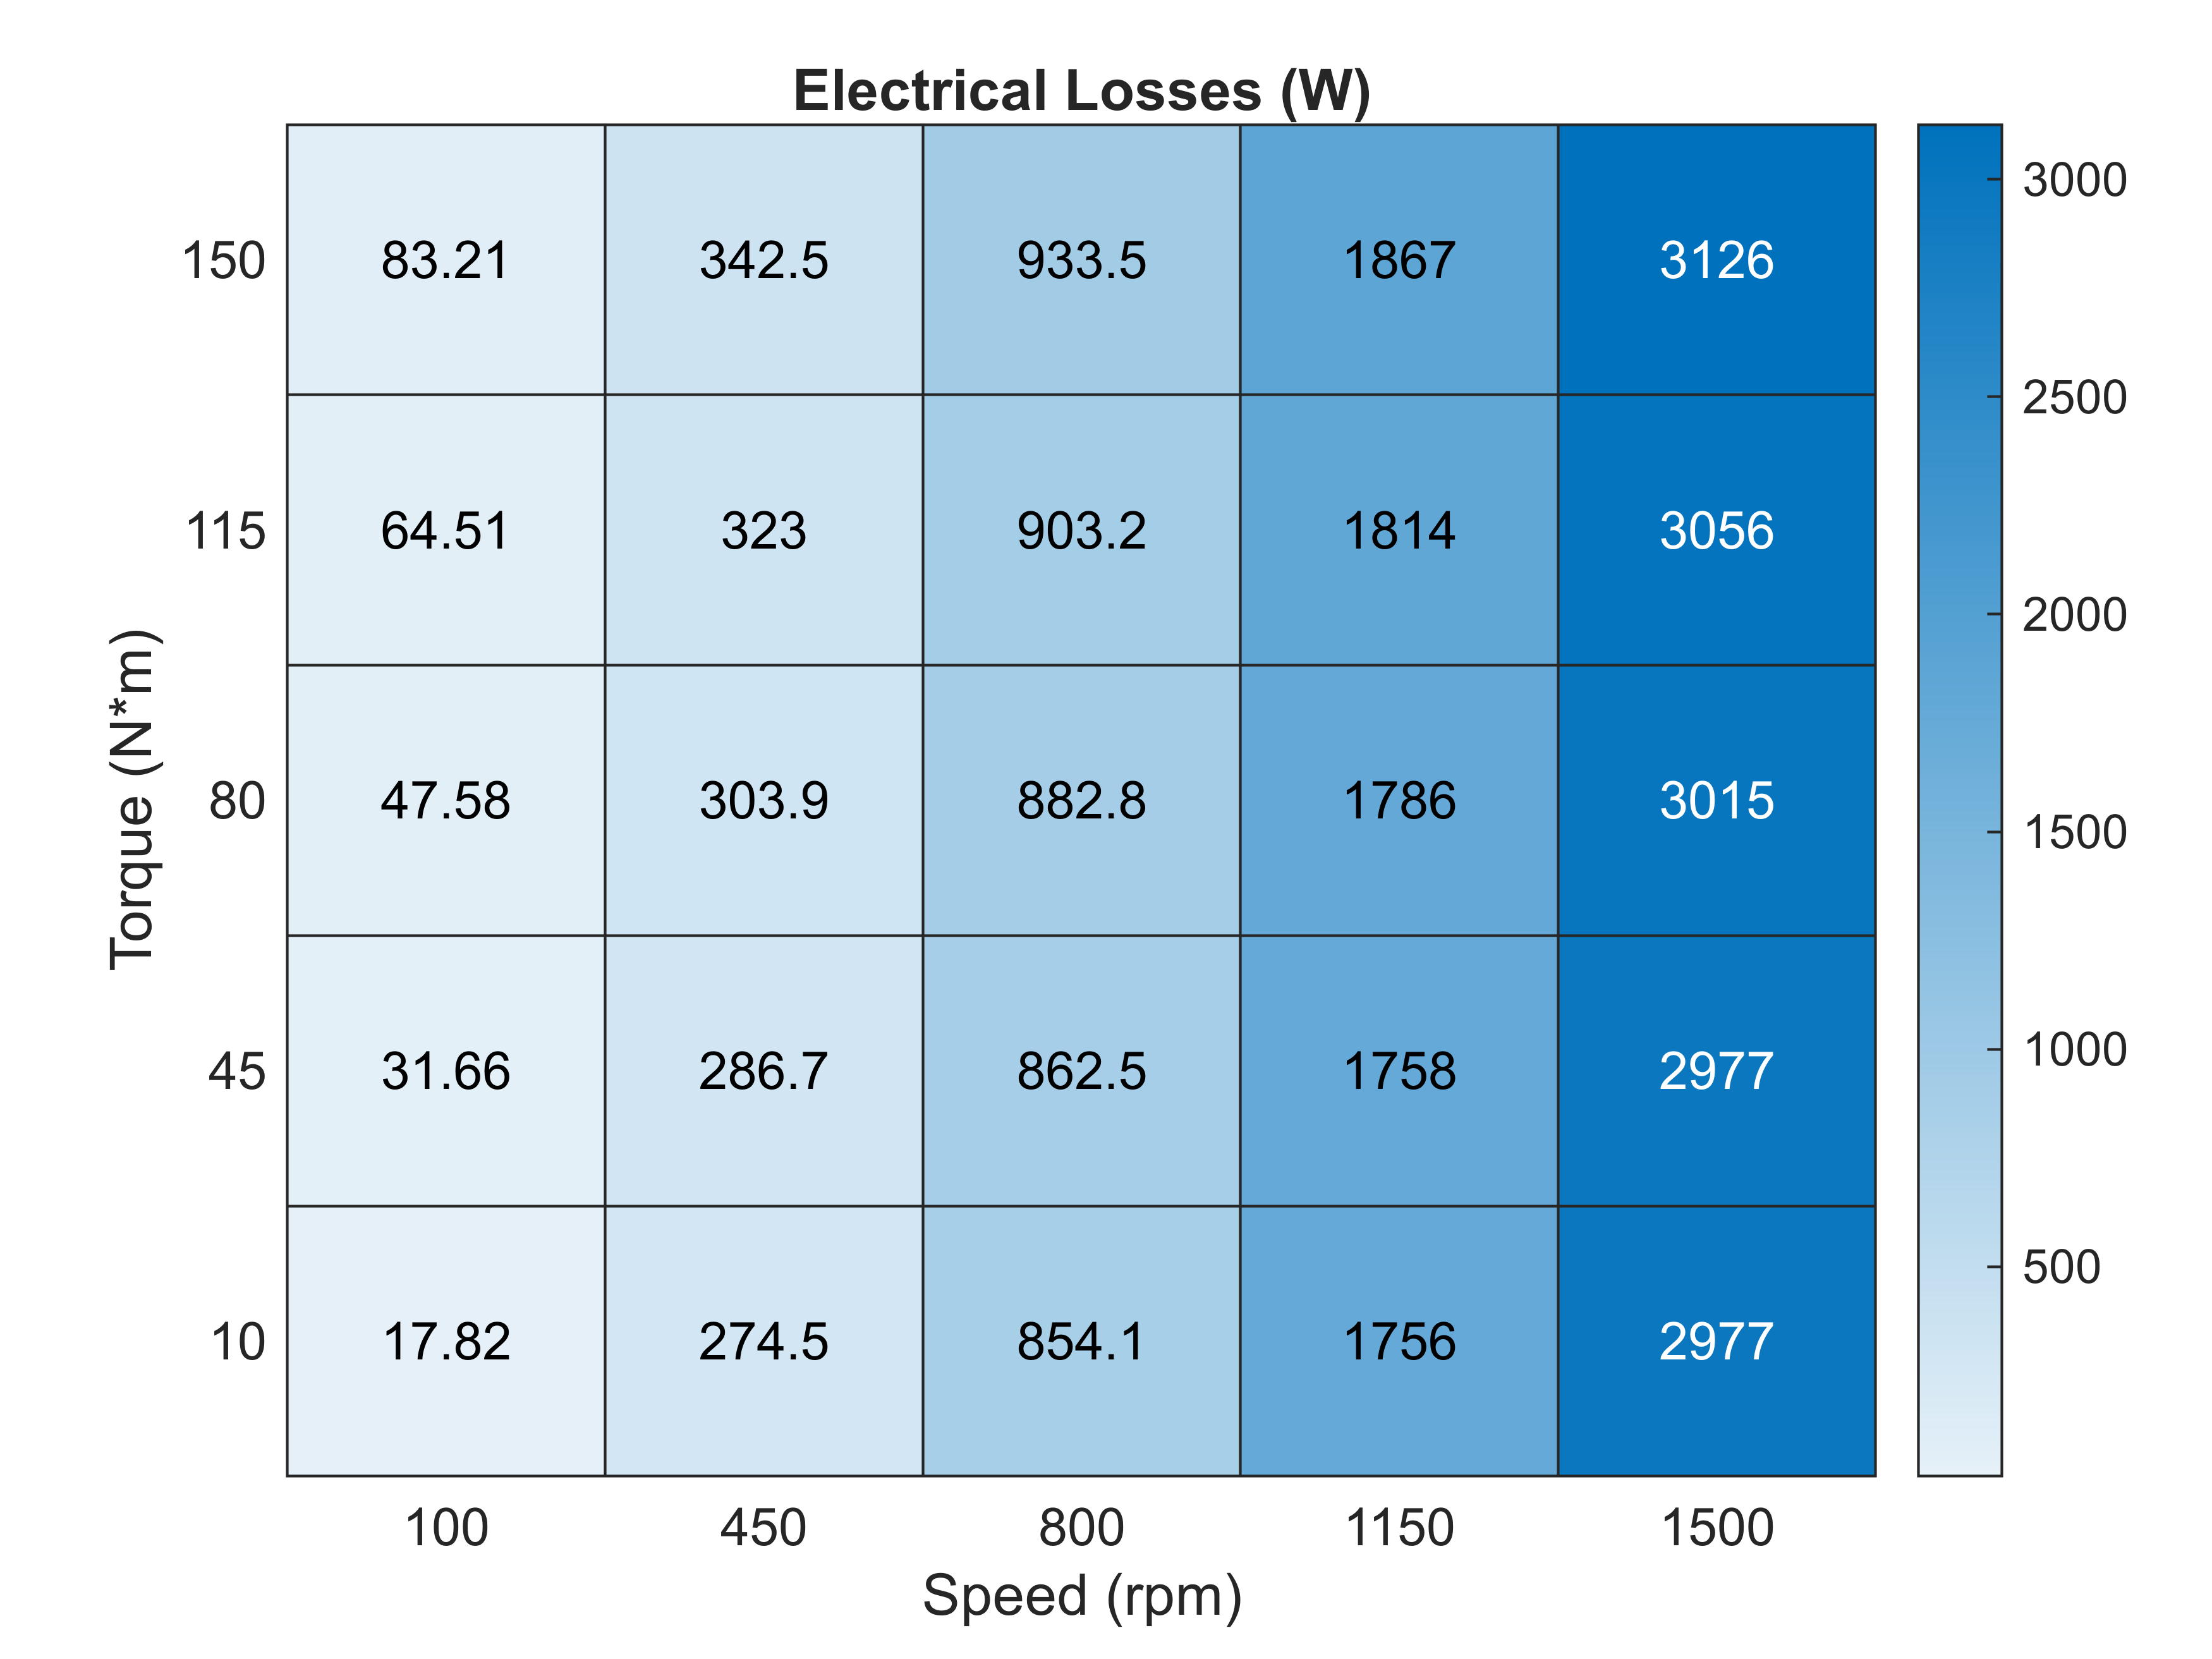

In [6]:
SpeedVecLabels = cell(1,nS);
for idx = 1:nS
  SpeedVecLabels{idx} = num2str(SpeedVec(idx));
end

TorqueVecLabels = cell(1,nT);
for idx = 1:nT
  TorqueVecLabels{idx} = num2str(TorqueVec(idx));
end

figure
hmap = heatmap(SpeedVecLabels, TorqueVecLabels, Losses);
hmap.YDisplayData = flip(TorqueVecLabels);
hmap.Title = "Electrical Losses (W)";
hmap.XLabel = "Speed (rpm)";
hmap.YLabel = "Torque (N*m)";


**Store the result for use by other models**


You can use the tabulated electrical losses in **Simplified PMSM Drive** block in Simscape Electrical.


In [7]:
% Make sure the losses data is stored in a 2D matrix as Losses(SpeedVec, TorqueVec).
motorDrive.simplePmsmDrv_spdVec_rpm = SpeedVec;
motorDrive.simplePmsmDrv_trqVec_Nm = TorqueVec;
motorDrive.simplePmsmDrv_LossTbl_W = Losses;

saveFileFullPath = fullfile(topicFolderPath, "MotorDriveElecLossParams.mat");
save(saveFileFullPath, "motorDrive");
% The file is saved in the current folder.
%disp("Mat file was saved in "+pwd)


Save command stores the data in a mat file which is a binary file. For your information, a text version of the electrical losses parameter is provided in [MotorDriveElecLossParams_text.m](matlab:edit MotorDriveElecLossParams_text.m) (but loss values are rounded for simplicity).

